# Tutorial 0 - Introduction to fastDDM

Welcome to the introductory "zero" tutorial of this series! In this notebook, we'll explore the functionalities offered by **fastDDM**, a robust and efficient Python library specifically conceived to perform Differential Dynamic Microscopy analyses on microscopy image sequences.

### Purpose

The aim of this tutorial is to guide you through the basic functions and classes offered by **fastDDM**. Specifically, we will:

1. Load an image sequence with the help of `read_images()`.
2. Obtain a structure function from the image sequence and explore its properties.
3. Calculate the azimuthal average of the structure function.
4. Fit the azimuthal average to gain insights into the sample's dynamics.

## Setting up your workspace

We assume you have already installed **fastDDM** and the necessary packages required for scientific analysis, fitting, and visualization on your machine (refer to the main [README](../README.md)).

For this tutorial, we will need the [open-source microscopy videos](https://datashare.ed.ac.uk/handle/10283/4858) accompanying the paper [Bradley et al, *Soft Matter*, 2023, **19**, 8179](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c). Download all files and unzip the main folder (and the `Video_dataset.zip` within it) in the directory containing these tutorials. (Go grab a coffee, it will take a while.)

Your main directory tree will look like this:
```
.
├── DS_10283_4858
│   └── Video_dataset
│       └── third_vid_dataset
├── Tutorial_0-Introduction
└── Tutorial_1-Particle_sizing
```

The movies represent colloidal particles of different sizes undergoing Brownian motion. For the moment, we will not care much about what these samples actually are and how they are prepared. We will discuss a bit more about them in the next tutorial.

## Fasten your seatbelts!

Let's start working with our images. We begin by importing some standard Python packages and fastDDM.

In [1]:
%matplotlib notebook

import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels indicating the nominal particle size.

In [2]:
# directory containing the videos
main_directory = '../DS_10283_4858/Video_dataset/third_vid_dataset/27_07_2021_BF_Scaling_Neat/'

# file names (including enclosing folder)
file_names = [
    'BF20x_1x1_200fps_Pos3_3/BF20x_1x1_200fps_Pos3_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos1_3/BF20x_1x1_200fps_Pos1_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos4_3/BF20x_1x1_200fps_Pos4_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos0_3/BF20x_1x1_200fps_Pos0_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos5_3/BF20x_1x1_200fps_Pos5_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos2_3/BF20x_1x1_200fps_Pos2_3_MMStack_Default.ome.tif',
]

# create full paths
file_paths = [os.path.join(main_directory, fn) for fn in file_names]

# list of labels
labels = [
    '60 nm',
    '120 nm',
    '240 nm',
    '500 nm',
    r'1.1 $\mu$m',
    r'2.1 $\mu$m',
]

The experimental parameters are listed in Sec. 4 of the reference [paper](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).
Videos are acquired at 200 fps with a Hamamatsu Orca Flash 4.0 camera (pixel size 6.5 $\mu$m) using a 20$\times$, NA 0.5 objective. This gives an effective pixel size of $\delta_{px} = 6.5/20 \, {\mu\mathrm{m}} = 325 \, \mathrm{nm}$.

In [3]:
# experimental parameters
frame_rate = 200       # frames per second
pixel_size = 6.5/20    # microns per pixel

It's always useful to begin by inspecting the videos. We'll load the first frame from each movie and display the images in a grid.

<IPython.core.display.Javascript object>


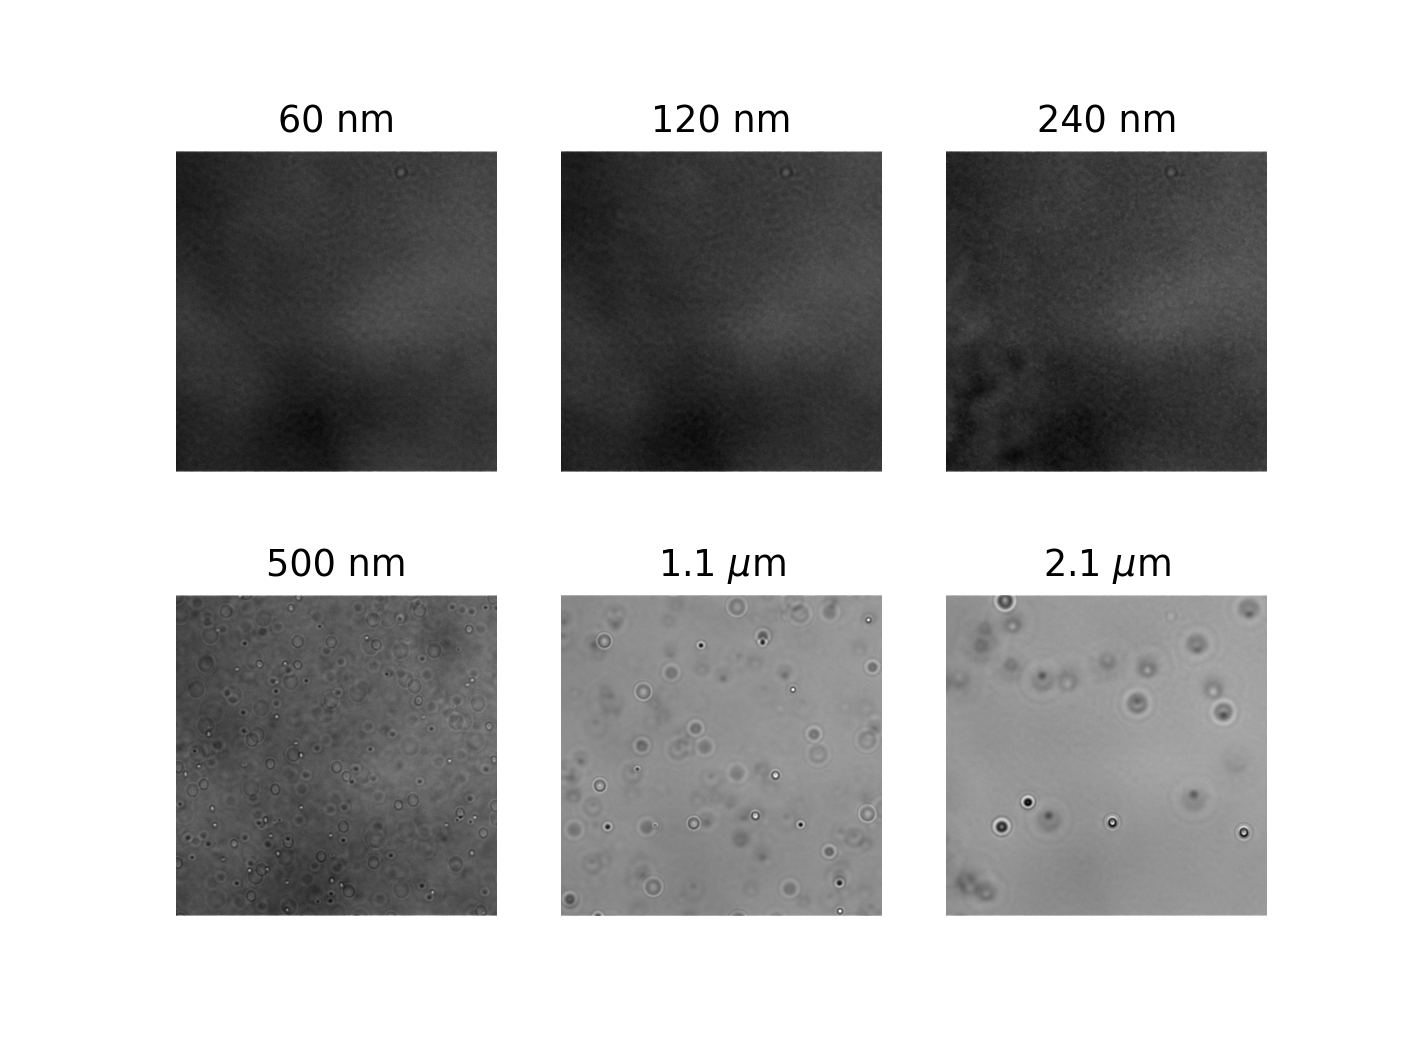

In [4]:
fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=3, nrows=2)
axs = gs.subplots()

# read the images
images = []
for path in file_paths:
    images.append(fd.read_images(path, seq=[0]))

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

Observe that the particles are visible only in the lower panels (500 nm to 2.1 $\mu$m), whereas they remain indiscernible in the upper panels due to their size being too small to be optically resolved.

## Structure function calculation

The structure function stands as a foundation tool for unveiling spatial correlations and dynamic features within images.

The process for the calculation is as follows:

1. **Data preparaton:** We initiate the process by loading the image sequence from the file. To compute the structure function, **fastDDM** requires a 3D NumPy array as input. The time runs over the first axis, while the spatial dimensions (y and x) run over the last two axes.
2. **Structure function calculation:** Subsequently, we apply DDM to the image sequence to derive the structure function. To provide the necessary experimental context, we input the frame rate and pixel size. These parameters update the time delays ($\Delta t$) and wave vectors ($k$). Bear in mind that these quantities have associated units.

We start the analysis by focusing on just one video to illustrate the procedure. For this purpose, we utilize the image sequence corresponding to the PS 240 nm sample. In the upcoming tutorial, we will extend our analysis to all the other movies.

In [5]:
# the index corresponding to the PS 240 nm is 2
idx = 2

# we select the path to the file ...
path = file_paths[idx]

# ... and the label
label = labels[idx]

# finally, we load the image sequence
img_seq = fd.read_images(path)

# let's see what is the shape of the image sequence
print(img_seq.shape)

(6000, 512, 512)


The shape of the array confirms that the videos consist of sequences of 6000 images, each with dimension of 512 $\times$ 512 pixels, as specified in the paper.

Now, let's visualize a selection of frames at different times.

<IPython.core.display.Javascript object>


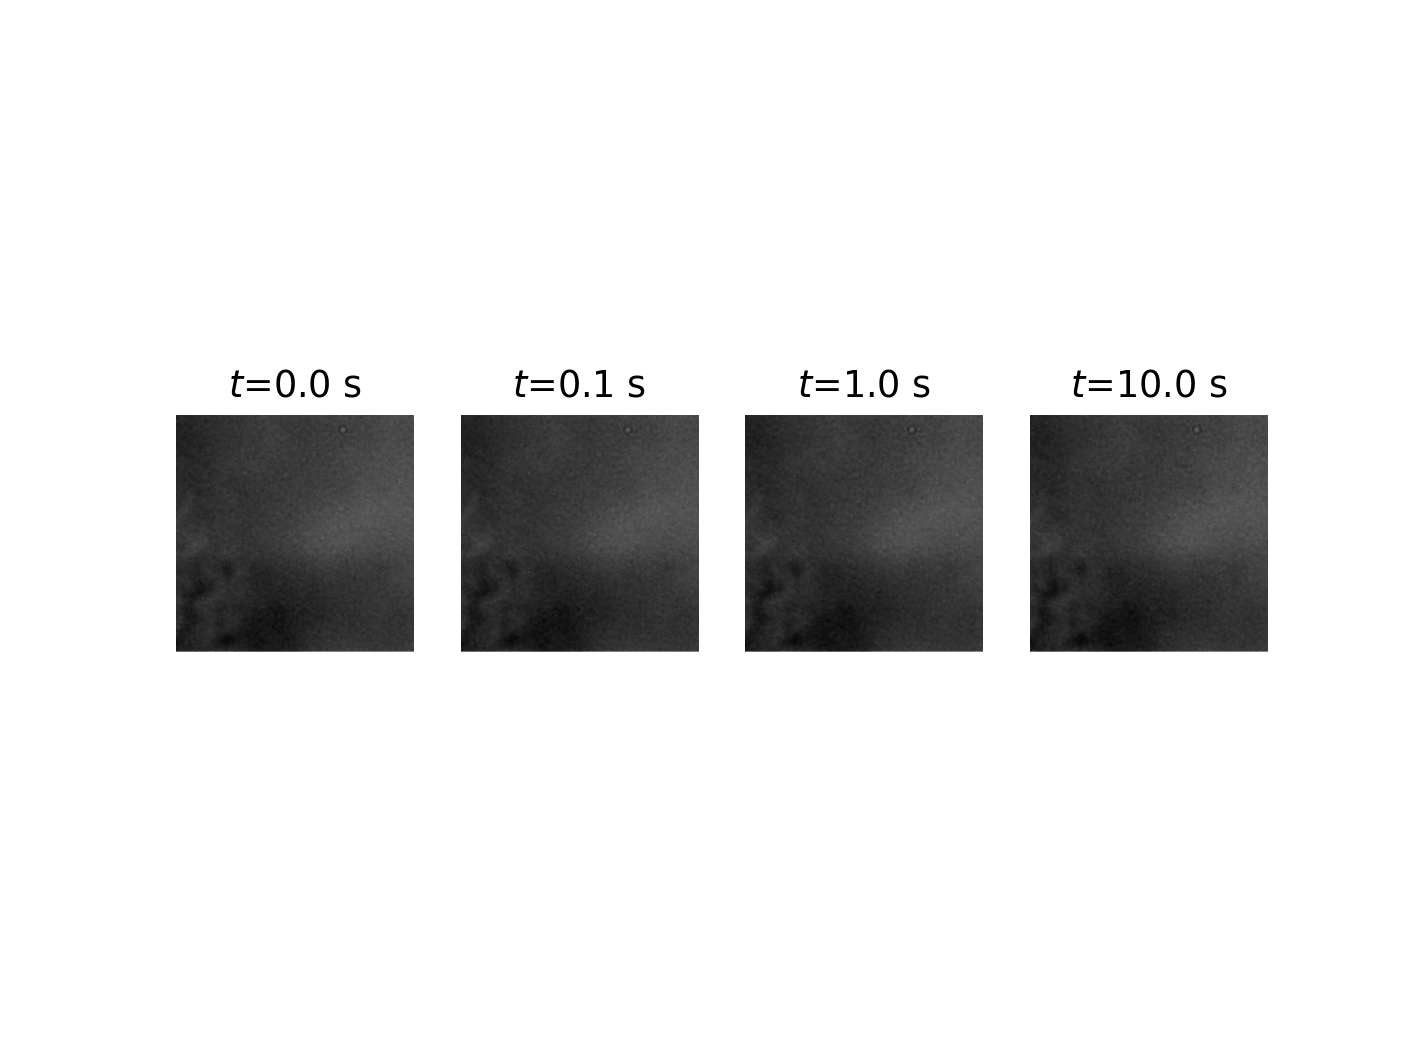

In [6]:
# we want to visualize the 0th, 20th, 200th, and 2000th frame
frame_indices = [0, 20, 200, 2000]

fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=len(frame_indices))
axs = gs.subplots()

for ax, fidx in zip(axs.flatten(), frame_indices):
    ax.imshow(img_seq[fidx], cmap='gray')
    
    # we compute the time delay between two images from the frame rate
    dt = 1 / frame_rate
    # title
    title = r'$t$' + f'={fidx * dt} s'
    
    ax.set_axis_off()
    ax.set_title(title)

The small signal from the particles causes all images to appear very similar, reflecting the spurious static signal generated along the optical path. However, by subtracting the first image...

<IPython.core.display.Javascript object>


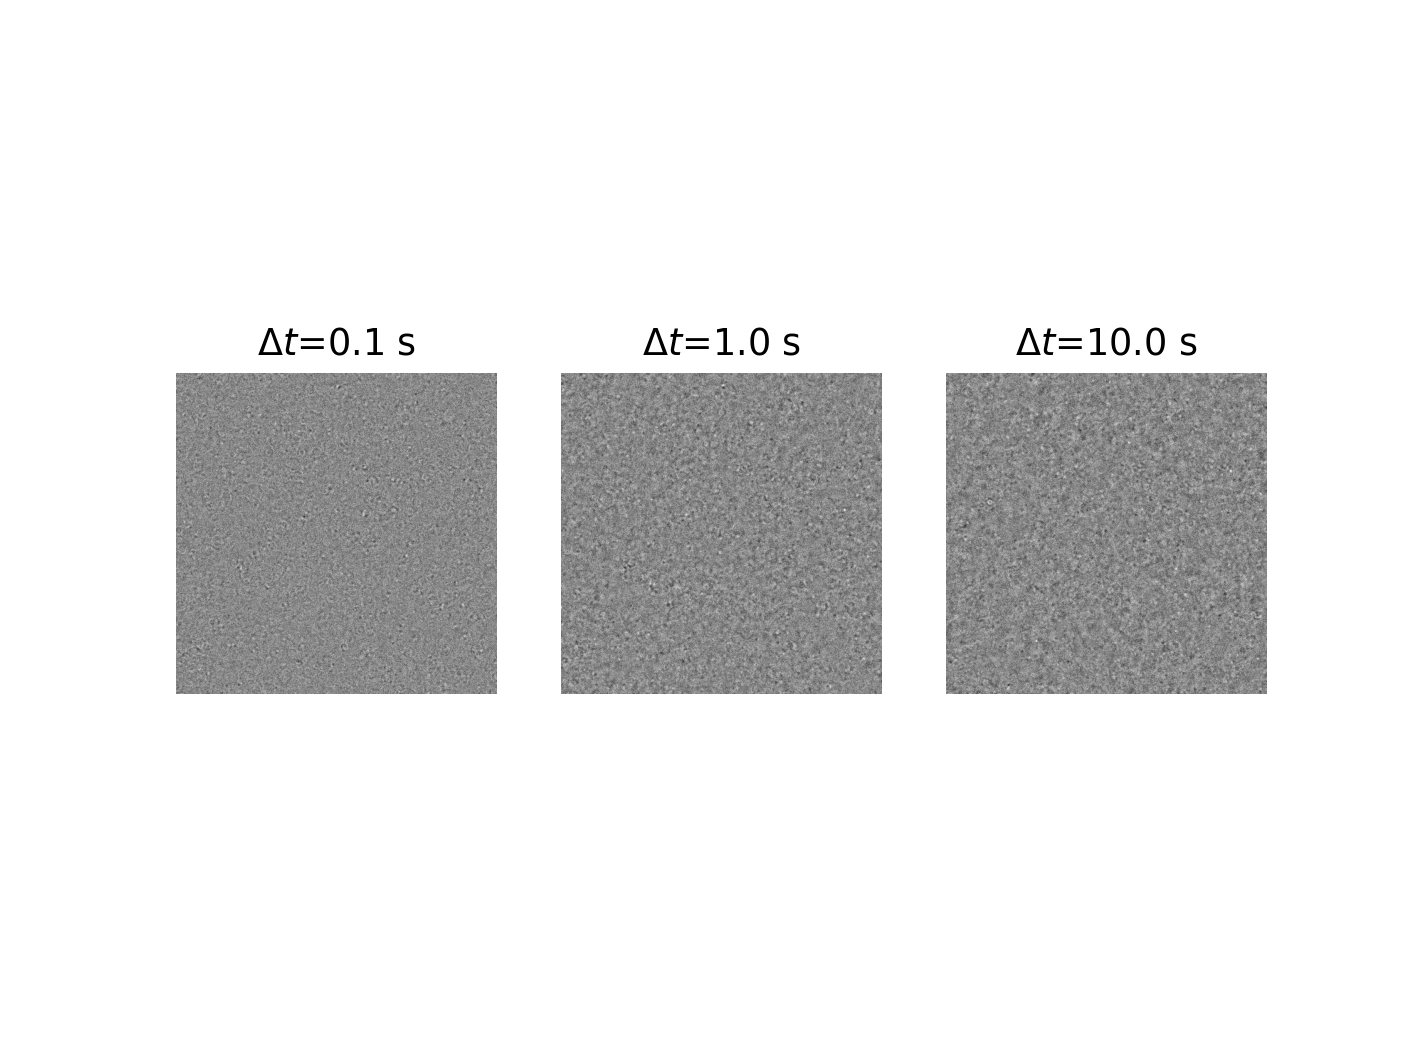

In [7]:
fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=len(frame_indices)-1)
axs = gs.subplots()

# calculate the image differences
delta_images = []
for fidx in frame_indices[1:]:
    delta_images.append(img_seq[fidx].astype(float)-img_seq[0])

for ax, d_img, fidx in zip(axs.flatten(), delta_images, frame_indices[1:]):
    ax.imshow(d_img,
              cmap='gray',
              vmin=np.min(delta_images),
              vmax=np.max(delta_images))
    
    # we compute the time delay between two images from the frame rate
    dt = 1 / frame_rate
    # title
    title = r'$\Delta t$' + f'={fidx * dt} s'
    
    ax.set_axis_off()
    ax.set_title(title)

Subtracting the reference image taken at time 0 effectively eliminates the static signal, unveiling the specific contribution from the particles. As we extend the time delay ($\Delta t$), the contrast in the resulting images intensifies, capturing the motion of the particles. Additionally, observing the average size of the granularity (speckles) in the difference images with longer time delays provides an estimate of the microscope's resolution, particularly when the particle size is below the resolution limit.

Now, let's delve into the calculation of the structure function, starting from the image sequence. Here's what happens under the hood:
1. Compute the spatial Fourier transform of the images, $I(\mathbf{q},t)=\mathcal{F}_{2D}\{i(\mathbf{x},t)\}$
2. Compute the structure function, defined as
   $$
   D(\mathbf{q},\Delta t) = \langle \lvert I(\mathbf{q}, t+\Delta t) - I(\mathbf{q}, t) \rvert^2 \rangle_t ,
   $$
   where $\langle \cdot \rangle_t$ indicates an average over time.


**FastDDM** offers various core backends for the structure function calculation: pure Python, C++, and CUDA.
These can be set by assigning `core` with the values `'py'`, `'cpp'`, and `'cuda'`, for Python, C++, and CUDA, respectively.
Uncomment the one you wish to use here (note that `'py'` is always available).

In addition, two algorithms have been implemented for the calculation of the structure function:
* the standard ('differences') algorithm, given by the definition above.
* the fast algorithm, which takes advantage of the Fast Fourier Transform (FFT) to speed up the computation.

These modes can be selected by assigning `mode` with the values `'diff'` and `'fft'` (the default), respectively.
The results in the two modes are virtually indistinguishable, but the `fft` mode will considerably speed-up your analysis. If you wish to test the difference, feel free to uncomment the `diff` mode (and enjoy your pause from work 🙂).

In [8]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
#CORE = 'py'
#CORE = 'cpp'
CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

Let's have a quick look at the documentation.

In [9]:
help(fd.ddm)

Help on function ddm in module fastddm._ddm:

ddm(img_seq: numpy.ndarray, lags: Iterable[int], *, core: str = 'py', mode: str = 'fft', window: Union[numpy.ndarray, NoneType] = None, **kwargs) -> fastddm.imagestructurefunction.ImageStructureFunction
    Perform Differential Dynamic Microscopy analysis on given image sequence.
    Returns the full image structure function.
    
    Parameters
    ----------
    img_seq : numpy.ndarray
        Image sequence of shape ``(t, y, x)`` where ``t`` is time.
    lags : Iterable[int]
        The delays to be inspected by the analysis.
    core : str, optional
        The backend core, choose between "py", "cpp", and "cuda".
        Default is "py".
    mode : str, optional
        The mode of calculating the structure function, choose between "diff"
        and "fft". Default is "fft".
    window : numpy.ndarray, optional
        A 2D array containing the window function to be applied to the images.
        Default is None.
    
    Returns
    -

In addition to the image sequence and the `core` and `mode` arguments we discussed earlier, the function also requires a sequence of `lags`. These are the indices used to evaluate the time lags $\Delta t$ used in the calculation of the structure function. If you prefer, these lags represent the time delays normalized by the minimum time difference between two images. (For now, let's set aside the `window` argument; we'll delve into it in one of the next tutorials.)

Several choices are possible. Two notable options include:
* A linear range between 1 and $N-1$, where $N$ is the number of images. (At $\Delta t = 0$ the signal is 0 by definition and does not carry any information.) This is the most natural one.
* A quasi-logarithmically spaced sequence of integers (if you want to test it, this can be obtained using the function `fastddm.lags.logspace_int()`). This produces points almost equally spaced in logarithmic (delay) time.

For this tutorial, we'll opt for the first option. Typically, one stops at half the length of the image sequence since, for increasing $\Delta t$, the statistics are reduced.

In [10]:
# define the sequence of lags
lags = range(1, int(len(img_seq) / 2))   # goes from 1 to len(img_seq)-1, included

# compute the image structure function
dqt = fd.ddm(img_seq, lags=lags, core=CORE, mode=MODE)

Well done! You've just calculated your first structure function with fastDDM! 🎉

Up to this point, there's still no experimental context. The time delays and wave vectors are currently non-dimensional:

In [11]:
print('--- Before experimental parameters setting ---')
# we can access the time delays through `tau` ...
print(dqt.tau)
# ... and the wave vectors over y via `ky`
print(dqt.ky)

--- Before experimental parameters setting ---
[1.000e+00 2.000e+00 3.000e+00 ... 2.997e+03 2.998e+03 2.999e+03]
[-3.14159265 -3.12932081 -3.11704896 ...  3.10477711  3.11704896
  3.12932081]


We can 'inform' the structure function object of the experimental parameters, such as the pixel size (for the wave vectors) and the frame rate (or the time delay between two images, for the time delays).

In [12]:
# to give some experimental context, we also set the pixel size ...
dqt.pixel_size = pixel_size
# ... and the frame rate
dqt.set_frame_rate(frame_rate)
# this can also be
# dqt.delta_t = 1/frame_rate

In [13]:
print('--- After experimental parameters setting ---')
print(dqt.tau)
print(dqt.ky)

--- After experimental parameters setting ---
[5.0000e-03 1.0000e-02 1.5000e-02 ... 1.4985e+01 1.4990e+01 1.4995e+01]
[-9.66643893 -9.62867941 -9.59091988 ...  9.55316035  9.59091988
  9.62867941]


You will need to keep in mind that these quantities have units!

Let's examine the structure function at different delay times, using the same values as those used for the visualization of image differences earlier. To correctly display the structure function (and also to calculate the azimuthal average in the next step), we need to exclude the cross corresponding to `kx, ky = 0`. This region contains artificially large contributions due to image processing artifacts.

<details><summary><h4>Bonus track (click me)</h4></summary>
    To save memory space, only the right half plane of the structure function is kept in memory (the one accessed through dqt.data), owing to the hermitian symmetry of the image Fourier transform. In fact, structure functions can become quite large. To obtain the full 2D representation, one can use the dqdt.full_shape() function, as we do below.
</details>

<IPython.core.display.Javascript object>


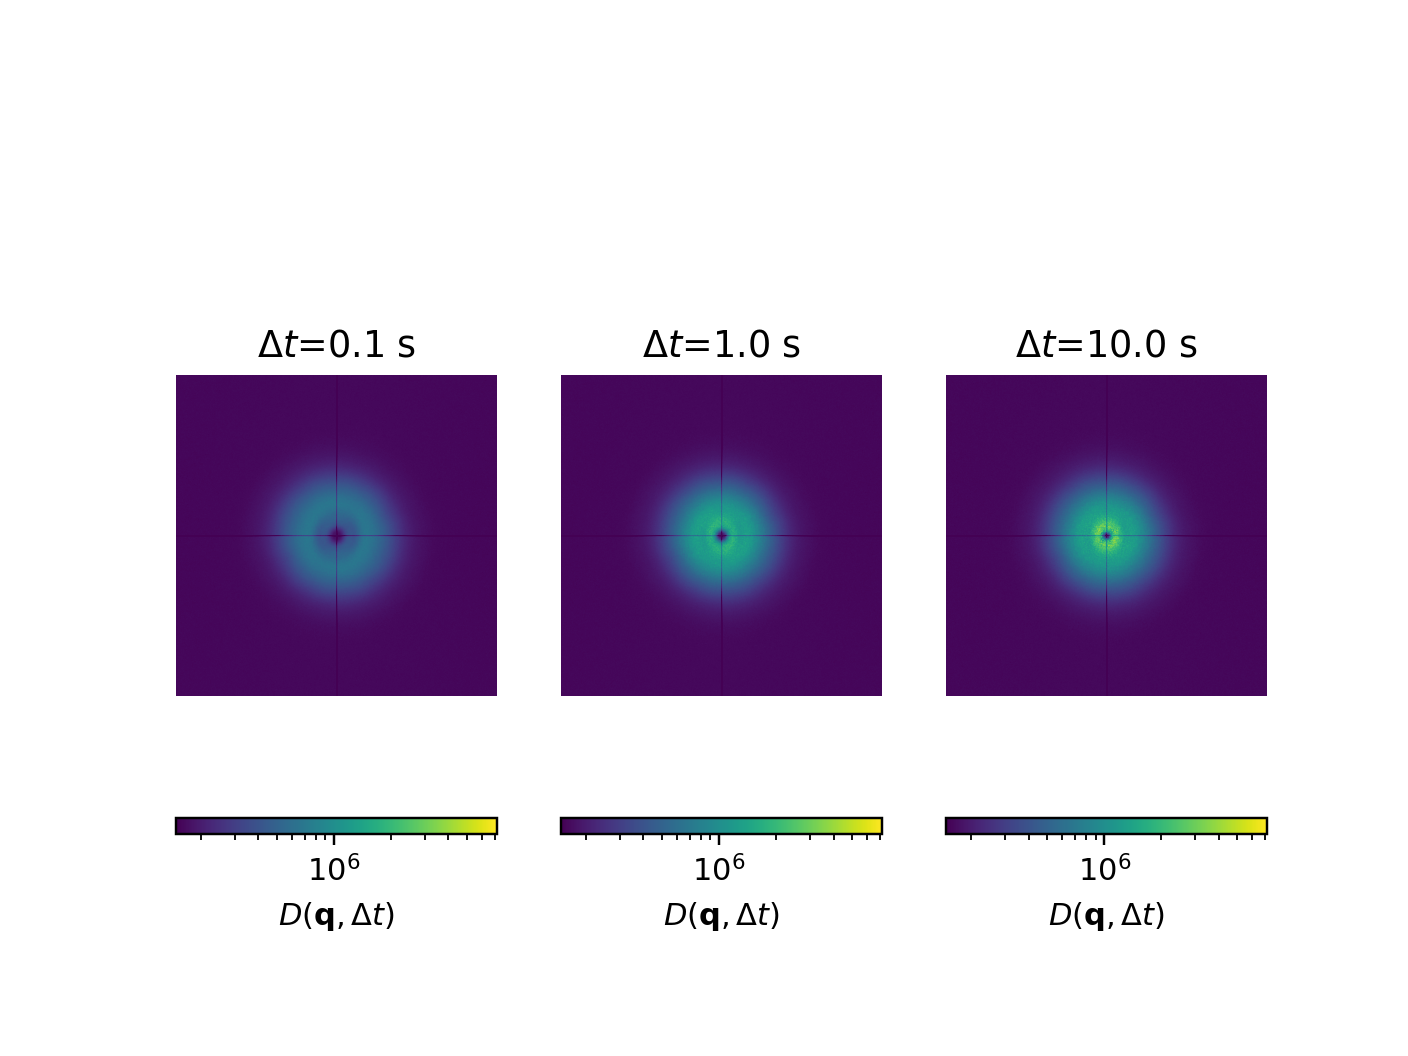

In [14]:
# calculate the indices relative to the image differences shown before
deltat_indices = [fidx - 1 for fidx in frame_indices[1:]]

fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=len(deltat_indices))
axs = gs.subplots()

# we need to mask the large signal in the central cross
shape_2d = dqt.full_shape()[1:]               # we just need the last two dimensions
dqt_mask = np.ones(shape_2d)
dqt_mask[int(shape_2d[0] / 2)] = 0
dqt_mask[:, int(shape_2d[1] / 2)] = 0

# get minimum and maximum values for better visualization
vmin = np.inf
vmax = 0
for dt in deltat_indices:
    _vmin = np.min(dqt.full_slice(dt)[dqt_mask.astype(bool)])
    vmin = _vmin if _vmin < vmin else vmin
    _vmax = np.max(dqt.full_slice(dt)[dqt_mask.astype(bool)])
    vmax = _vmax if _vmax > vmax else vmax

# plot the structure functions
for ax, dt_idx in zip(axs.flatten(), deltat_indices):
    pos = ax.imshow(dqt.full_slice(dt_idx) * dqt_mask,
                    cmap='viridis',
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    title = r'$\Delta t$' + f'={dqt.tau[dt_idx]} s'
    
    ax.set_axis_off()
    ax.set_title(title)
    fig.colorbar(pos, ax=ax, location='bottom', label=r'$D(\mathbf{q}, \Delta t)$')

Similarly to what we observe for the image differences, the contrast of the structure function increases with $\Delta t$.

## Azimuthal average calculation
For isotropic systems, enhancing statistics is achieved by binning the modulus of the 2D wave vectors and averaging the structure function over the wave vector annuli
$$
d(q, \Delta t) = \langle D(\mathbf{q}, \Delta t) \rangle_{\lvert \mathbf{q} \rvert \in (q_{\mathrm{inf}}, q_{\mathrm{sup}}] } ,
$$
where $(q_{\mathrm{inf}}, q_{\mathrm{sup}}]$ indicates the bin range relative to the $q$ of interest.

A generally good choice for the azimuthal average is to choose the bins so that the wave vector modulus runs from 0 to the maximum `kx, ky`, with a bin spacing equal to the wave vector spacing over one pixel.

<details><summary><h4>Bonus track (click me)</h4></summary>
    In case of asymmetric images (namely, when the number of pixels in one direction is different from the other), a better solution for the bin size is to use the wave vector spacing over one pixel that is largest between the two directions.
</details>

To compute the azimuthal average, we use the dedicated function `fastddm.azimuthal_average()`. Let's have a look at the documentation.

In [15]:
help(fd.azimuthal_average)

Help on function azimuthal_average in module fastddm.azimuthalaverage:

azimuthal_average(img_str_func: fastddm.imagestructurefunction.ImageStructureFunction, bins: Union[int, Iterable[float], NoneType] = 10, range: Union[Tuple[float, float], NoneType] = None, mask: Union[numpy.ndarray, NoneType] = None, weights: Union[numpy.ndarray, NoneType] = None, eval_err: Union[bool, NoneType] = True) -> fastddm.azimuthalaverage.AzimuthalAverage
    Compute the azimuthal average of the image structure function.
    
    For every (not masked out) :math:`k` wavevector in the :math:`i`-th bin,
    the average is calculated as
    
    .. math:
    
        \bar{x}_i = \frac{\sum_k w_k x_k}{\sum_k w_k} ,
    
    where :math:`w_k` is the weight given to the wavevector :math:`k`.
    The uncertainty is calculated as the square root of the variance for
    weighed measures
    
    .. math:
    
        \text{Var}(x_i) = \left( \frac{\sum_k w_k x_k^2}{\sum_k w_k} - \bar{x}_i^2 \right) \frac{N_i}{N_i -

As one can expect, the function requires the structure function as an input. Similar to the numpy `histogram` function, it also requires the number of equal-width bins and the (lower and upper) range of the bins. As discussed earlier, we will use a number of bins equal to half the number of pixels in one direction (we are dealing with square images) and a range from 0 to the maximum `ky` value.

Additionally, the function allows to input a boolean mask to exclude specific points from the average. As done before, we would like to exclude the spurious signal present in the central cross of the structure function. To achieve this, we will use the `fastddm.mask.central_cross_mask()` helper function.

In [16]:
# number of bins
bins = int(len(dqt.ky) / 2)
# bin range
bin_range = (0, dqt.ky[-1])

print(f'Number of bins: {bins}')
print(f'Bin range: {bin_range}')

Number of bins: 256
Bin range: (0, 9.628679407036024)


In [17]:
# get the mask for the central cross
ccm = fd.mask.central_cross_mask(shape_2d)

# compute the azimuthal average
aa = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)

Now, let's visualize the azimuthal average at different selected wave vectors.

<IPython.core.display.Javascript object>


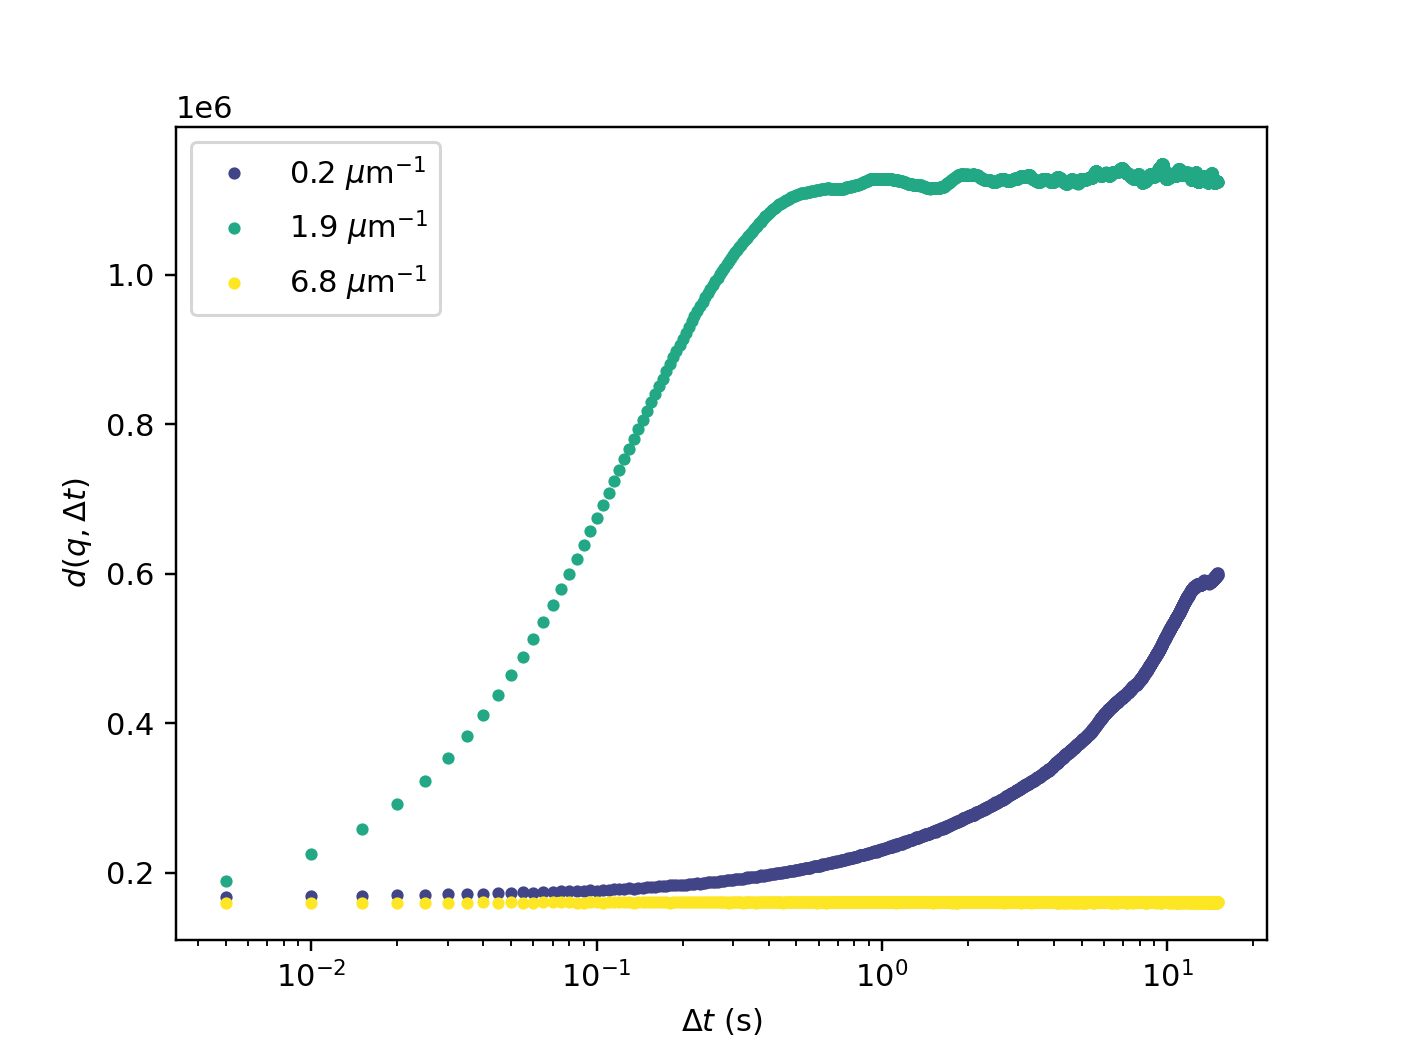

In [18]:
# select wave vectors indices
k_indices = [5, 50, 180]
# create colors
cspace = color_space(len(k_indices))

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(1,1,1)

for n, (k_idx, c) in enumerate(zip(k_indices, cspace)):
    ax.plot(aa.tau, aa.data[k_idx], '.', color=c, label=f'{aa.k[k_idx]:.1f}' + r' $\mu$m$^{-1}$')

ax.set_xscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$d(q, \Delta t)$')
ax.legend();

The structure function grows with $\Delta t$, reaching a plateau at large delay times. This quantity is connected to the intermediate scattering function $f(q, \Delta t)$, which one can measure in scattering experiments, through
$$
d(q, \Delta t) = A(q) [1 - f(q, \Delta t)] + B(q)
$$

For $\Delta t \to 0$, the function starts at $B(q)$ - which is related to the camera noise - and reaches a constant value $A(q) + B(q)$. The amplitude $A(q)$ contains information about the sample's static properties and the optical system used.

The total amplitude can be estimated from the variance (in time) of the Fourier-transformed image sequence

$$
A(q) + B(q) \simeq 2 \mathrm{var}_t\{ I(\mathbf{q}, t) \}
$$

To estimate the noise term, different methods have been devised in the past, which can be found in the literature. Keeping the constant coefficient of a quadratic fit of the first few points of the structure function seems to work fine in many cases of interest. In general, it can serve as an initial input for fitting the data or run adaptive algorithms.

To illustrate this, we estimate the amplitude and noise terms as we just discussed, providing a first estimate of the intermediate scattering function.

In [19]:
# estimate the noise term
Bq, Bq_err = fd.noise_est.estimate_camera_noise(aa, mode='polyfit', num_points=5)

# estimate total amplitude
Aq_plus_Bq = 2 * aa.var

# estimate static amplitude
Aq = Aq_plus_Bq - Bq

From the estimated amplitude and noise, the intermediate scattering function can be simply obtained by

$$
f(q, \Delta t) = 1 - \frac{d(q, \Delta t) - B(q)}{A(q)}
$$

<IPython.core.display.Javascript object>


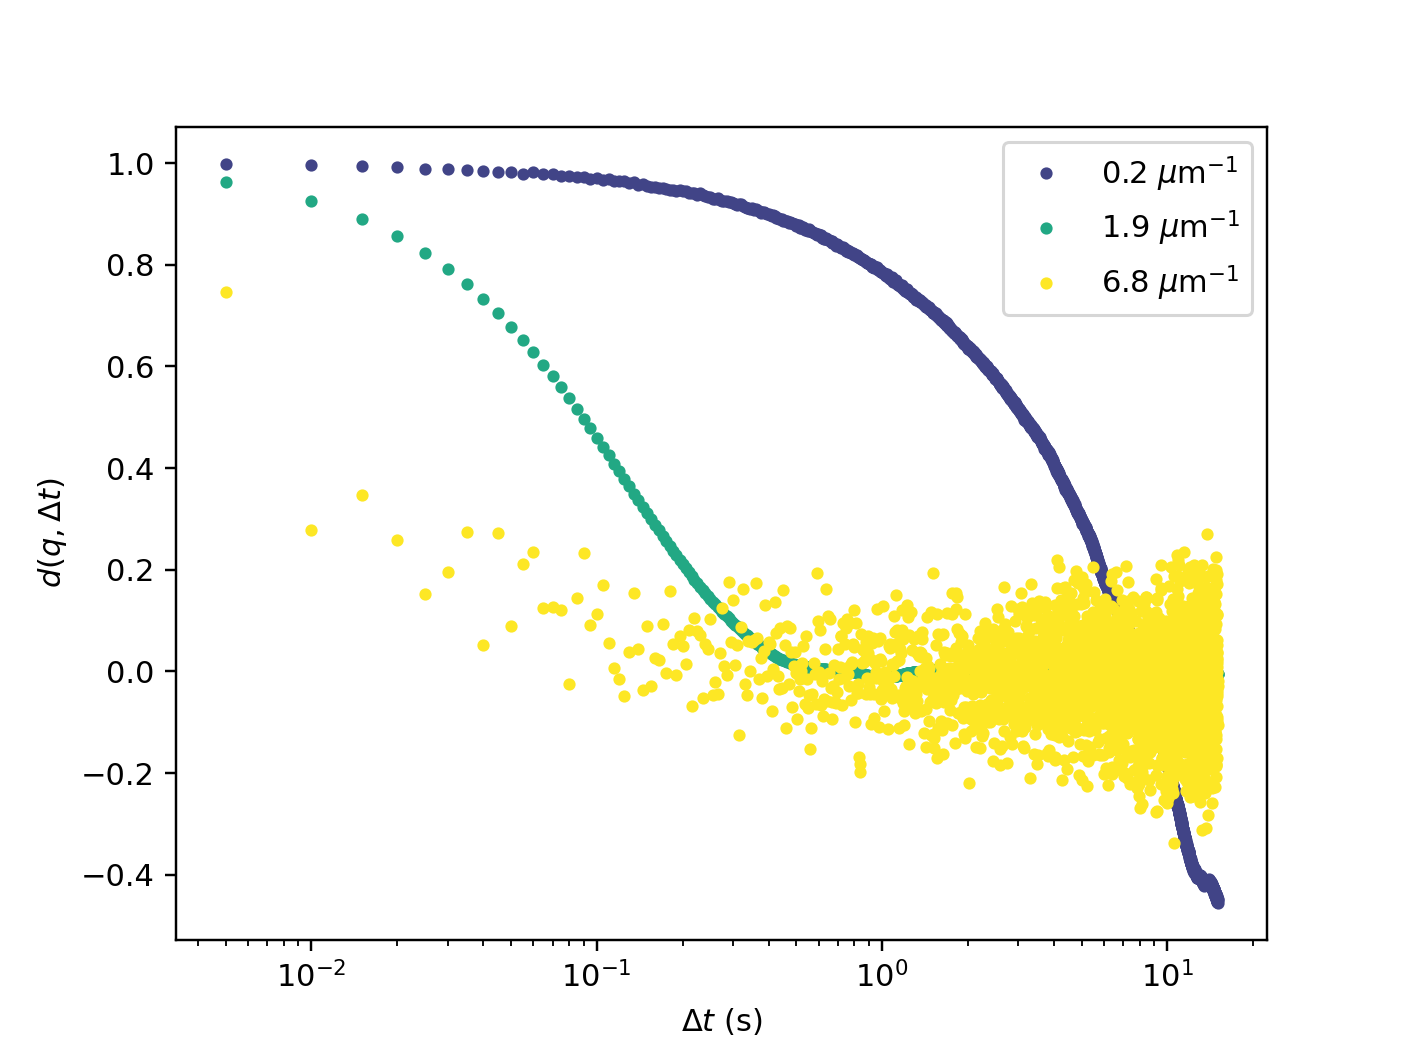

In [20]:
# we plot the estimated intermediate scattering function
# corresponding to the same wave vectors as before
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(1,1,1)

for n, (k_idx, c) in enumerate(zip(k_indices, cspace)):
    fqt = 1 - (aa.data[k_idx] - Bq[k_idx]) / Aq[k_idx]
    ax.plot(aa.tau, fqt, '.', color=c, label=f'{aa.k[k_idx]:.1f}' + r' $\mu$m$^{-1}$')

ax.set_xscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$d(q, \Delta t)$')
ax.legend();

Clearly, the structure function can be effectively inverted only when the parameters can be correctly estimated, which is seldom the case at very small wave vectors (due to the slow dynamics) or at very large wave vectors (where no signal from the image is present, due to the limited numerical aperture of the system).

## Fit of the structure function

With a model for the intermediate scattering function and starting from the initial estimate of the parameters of the structure function, we can fit the structure function to extract useful information on the sample's dynamics.
For particles undergoing Brownian motion, the intermediate scattering function is well-described by a simple exponential function:

$$
f(q, \Delta t) = \exp [- \Gamma(q) \Delta t] ,
$$
where $\Gamma(q) = D q^2$ is the relaxation rate and $D$ is the particles' diffusion coefficient.

Among the models offered by fastDDM, we can use the `fastddm.fit_models.simple_exponential_model`, which implements the exponential function in the structure function model:

$$
d(q, \Delta t) = A(q) [1 - \exp(-\Gamma(q) \Delta t)] + B(q) .
$$

The `fastddm.fit.fit_multik()` is a utility routine that allows fitting an azimuthal average of the structure function for all the wave vectors, starting from a reference one `k_ref`, and reusing the previous results as a starting point for the next fit.

In [21]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

We can have a look at the documentation of the `fit_multik` function.

In [22]:
help(fit_multik)

Help on function fit_multik in module fastddm.fit:

fit_multik(data: Union[fastddm.azimuthalaverage.AzimuthalAverage, fastddm.intermediatescatteringfunction.IntermediateScatteringFunction], model: lmfit.model.Model, ref: int, ref_params: Union[lmfit.parameter.Parameters, NoneType] = None, return_model_results: Union[bool, NoneType] = False, use_err: Union[bool, NoneType] = False, fixed_params: Union[Dict[str, Sequence[float]], NoneType] = None, fixed_params_min: Union[Dict[str, Sequence[float]], NoneType] = None, fixed_params_max: Union[Dict[str, Sequence[float]], NoneType] = None, fixed_params_expr: Union[Dict[str, Sequence[str]], NoneType] = None, **fitargs: Any) -> Tuple[pandas.core.frame.DataFrame, Union[List[lmfit.model.ModelResult], NoneType]]
    A wrapper for fitting a given model to given data for multiple :math:`k` vectors.
    
    The initial parameters estimated for ``ref`` index should be set in the model
    or passed to the function (via ``ref_params`` or as keyword arg

To initiate a fitting process with a reliable starting value for the relaxation rate, we can estimate $\tau = 1/\Gamma$ by first estimating the intermediate scattering function and determining the delay where it has a value of $1/\mathrm{e}$.

In [23]:
# find reference tau
fqt = 1 - (aa.data[k_ref] - Bq[k_ref])/Aq[k_ref]
tau = aa.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    
# set model parameters hints
model.set_param_hint("B", value=Bq[k_ref])
model.set_param_hint("A", value=Aq[k_ref])
model.set_param_hint("Gamma", value=1/tau)
    
# fit
fit_res, model_res = fit_multik(aa, model, k_ref, use_err=True, return_model_results=True)

The fit results are returned as a Pandas DataFrame. Let's take a look at them.

In [24]:
fit_res.head()

,A,B,Gamma,beta,A_stderr,B_stderr,Gamma_stderr,beta_stderr,success,k
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.018880
2,175398.643702,178231.628307,0.135225,1.0,3426.225374,70.027417,0.003180,0.0,True,0.053400
3,127109.218369,171206.597247,0.238453,1.0,540.392964,72.221513,0.001959,0.0,True,0.091889
4,125454.171955,173414.232586,0.318491,1.0,258.870538,76.503933,0.001676,0.0,True,0.127775


The fit returns $A(q)$ and $B(q)$, along with their uncertainties (denoted by `_stderr`). The parameter `Gamma` (with `Gamma_stderr`) quantifies the relaxation rate of the sample's dynamics at different `k`, according to the model. For convenience regarding later analysis, the fit results also include a `success` flag, that indicates whether the fit at that `k` was successful or not.

Armed with the parameters returned by the fit, we can we can once again attempt to invert the structure function to obtain the intermediate scattering function.

<IPython.core.display.Javascript object>


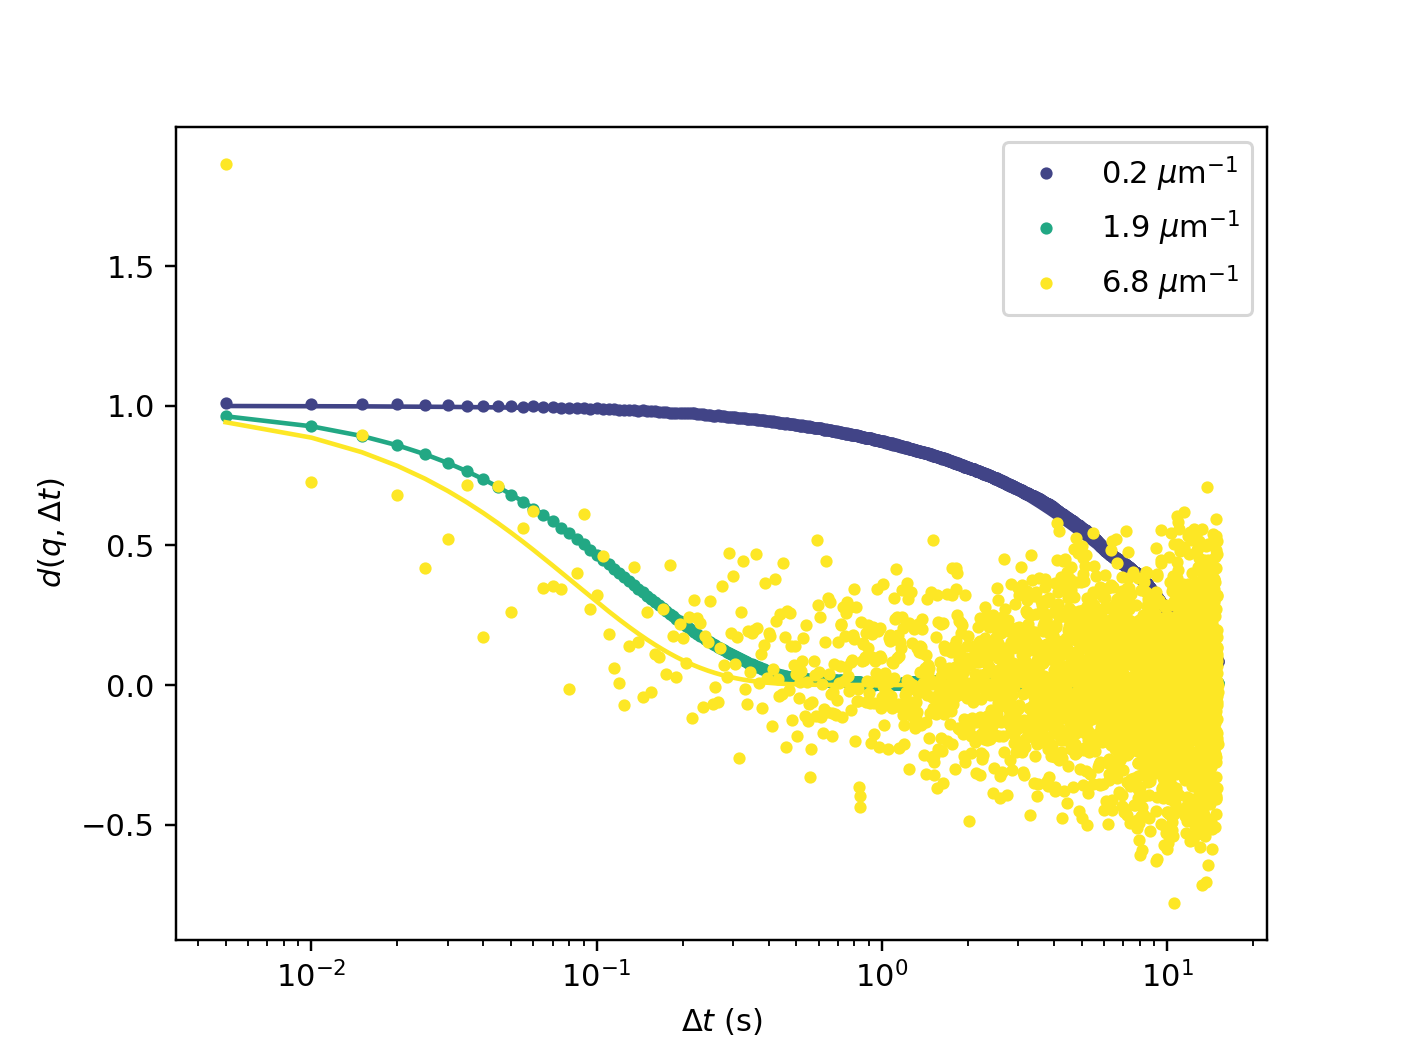

In [25]:
# we plot the intermediate scattering function inverted using the fit parameters
# corresponding to the same wave vectors as before
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(1,1,1)

for k_idx, c in zip(k_indices, cspace):
    fqt = 1 - (aa.data[k_idx] - fit_res['B'][k_idx]) / fit_res['A'][k_idx]
    fqt_fit = 1 - (model_res[k_idx].best_fit - fit_res['B'][k_idx]) / fit_res['A'][k_idx]
    ax.plot(aa.tau, fqt, '.', color=c, label=f'{aa.k[k_idx]:.1f}' + r' $\mu$m$^{-1}$')
    ax.plot(aa.tau, fqt_fit, '-', color=c)

ax.set_xscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$d(q, \Delta t)$')
ax.legend();

This process can be repeated for different wave vectors to assess the quality of the measurement and the obtained results.

<IPython.core.display.Javascript object>


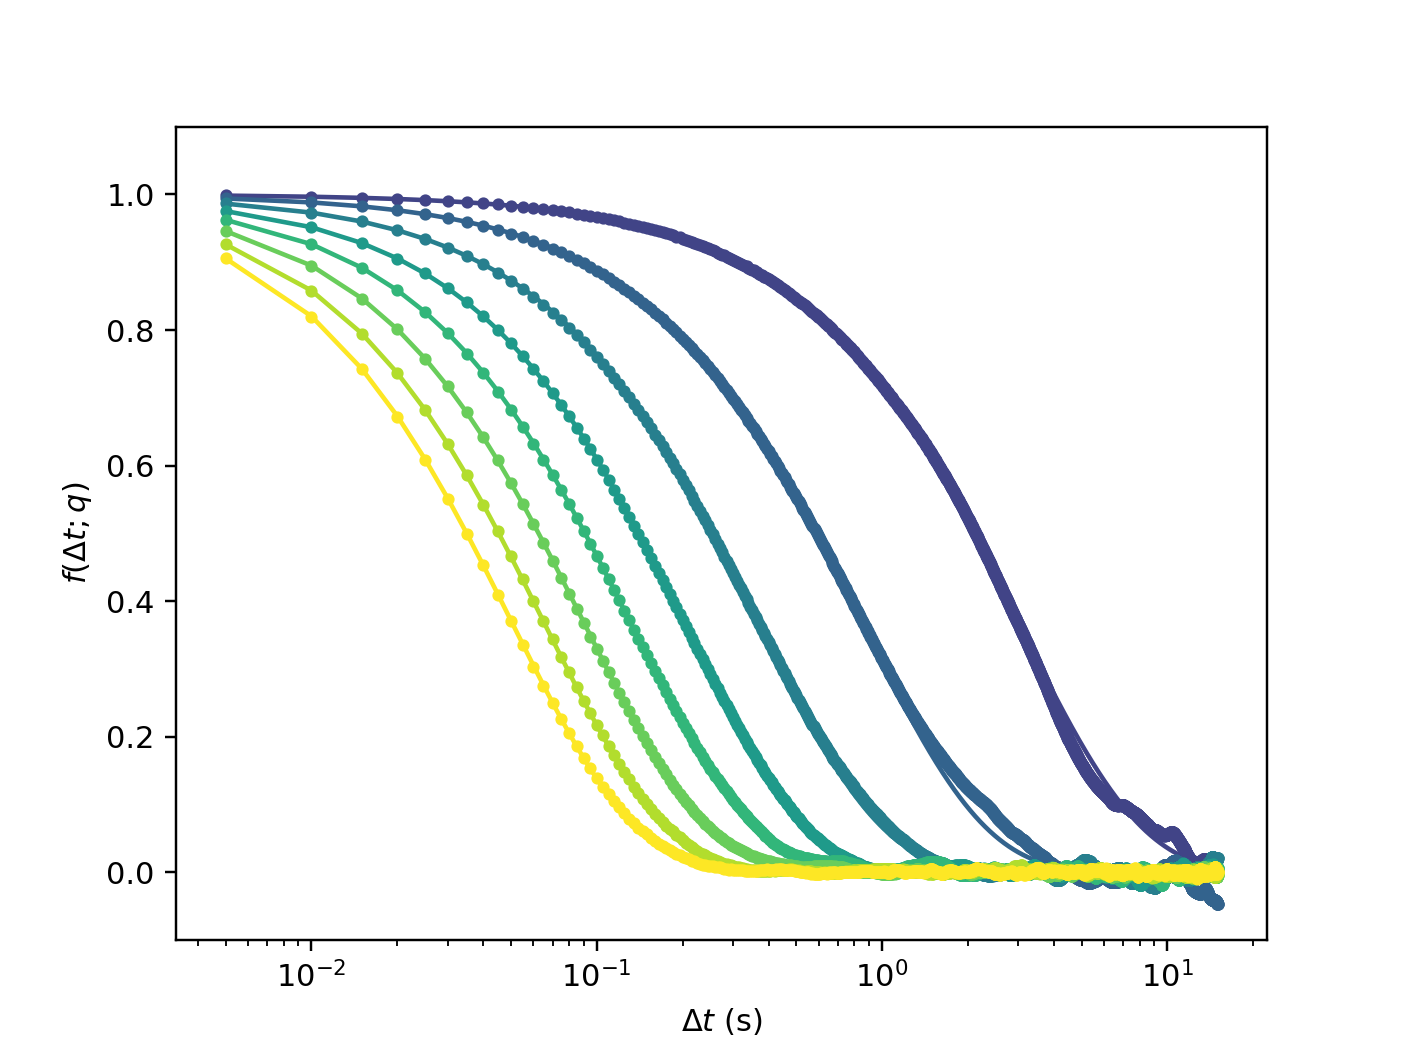

In [26]:
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(1,1,1)

# we plot curves from 10th to 80th wave vector every 10
k_range = list(range(10,81,10))
cspace = color_space(len(k_range))

for k_idx, c in zip(k_range, cspace):
    fqt = 1 - (aa.data[k_idx] - fit_res['B'][k_idx]) / fit_res['A'][k_idx]
    fqt_fit = 1 - (model_res[k_idx].best_fit - fit_res['B'][k_idx]) / fit_res['A'][k_idx]
    ax.plot(aa.tau, fqt, '.', color=c)
    ax.plot(aa.tau, fqt_fit, '-', color=c)

       
ax.set_xscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$f(\Delta t; q)$')
ax.set_ylim(-0.1, 1.1);

The intermediate scattering functions obtained from the fit appear satisfactory. Let's also examine the fitting parameters.

<IPython.core.display.Javascript object>


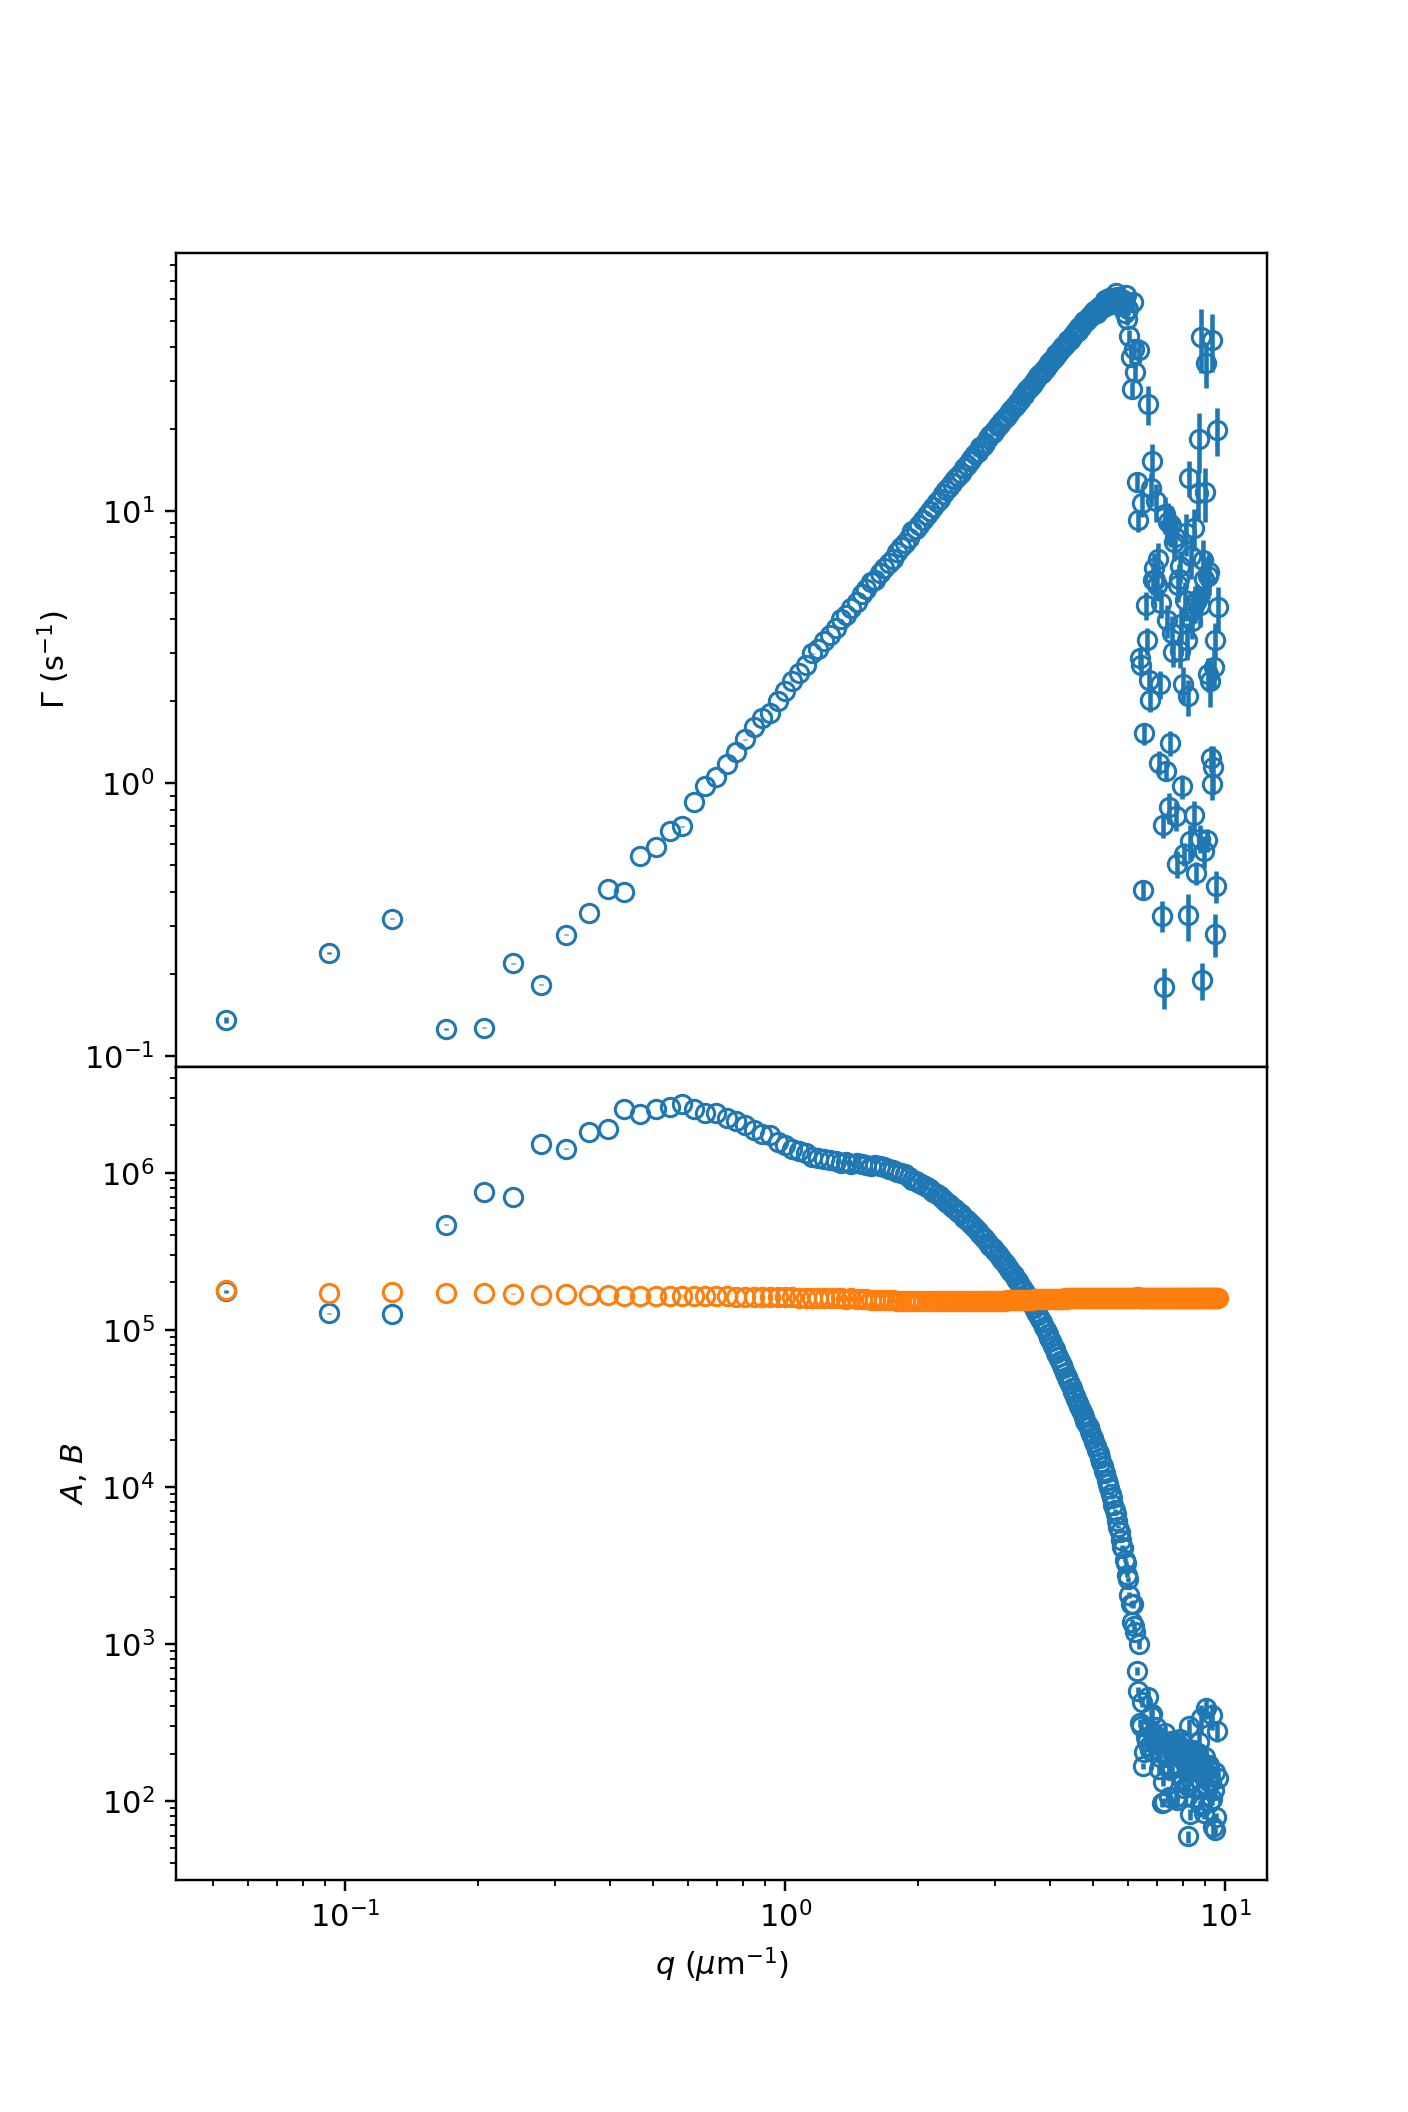

Text(0, 0.5, '$A$, $B$')

In [27]:
# plot fit parameters
fig = plt.figure()
fig.tight_layout()
fig.set_figheight(2.0 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# filter fit results
ffr = fit_res.dropna()
ffr = ffr[ffr['success']]

# plot Gamma
axs[0].errorbar(ffr['k'], ffr['Gamma'], yerr=ffr['Gamma_stderr'], fmt='o', markerfacecolor='none')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')

# plot A, B
axs[1].errorbar(ffr['k'], ffr['A'], yerr=ffr['A_stderr'], fmt='o', markerfacecolor='none')
axs[1].errorbar(ffr['k'], ffr['B'], yerr=ffr['B_stderr'], fmt='o', markerfacecolor='none')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_ylabel(r'$A$, $B$')

Congratulations! 🎉 You have successfully completed your first tutorial on Differential Dynamic Microscopy with fastDDM!

In the next tutorials, we will examine specific examples where DDM can provid useful insights on the static and dynamic properties of samples of interest, ranging from colloidal suspensions, to proteins and bacteria.
Some of the additional features offered by fastDDM will be illustrated within these tutorials, but you can get specific information on the classes and functions by exploring the documentation.

Well done! See you in the next tutorials! 😃

# Figures for paper

This last section is not part of the tutorial. If you are interested in getting the images used for our publication, feel free to set the following flag to `True` and run the cells below. You will need the `scienceplots` package, which is not among the ones required for these tutorials. You can install it through `pip`.

In [28]:
save_figures = False

In [29]:
if save_figures:
    import scienceplots

    plt.style.use(['science', 'nature', 'vibrant'])
    mpl.rcParams['lines.markeredgewidth'] = 0.7

### Export images

In [30]:
if save_figures:
    # save reference images at different times
    frame_indices = [0, 20, 200, 2000]

    fig = plt.figure()
    fig.tight_layout()
    ax = fig.add_subplot()

    # get min and max
    vmin = img_seq.min()
    vmax = img_seq.max()

    for n, fidx in enumerate(frame_indices):
        ax.imshow(img_seq[fidx], cmap='gray', vmin=vmin, vmax=vmax)
    
        # we compute the time delay between two images from the frame rate
        dt = 1 / frame_rate
        # title
        title = r'$t$' + f' = {fidx * dt!r} s'
    
        ax.set_axis_off()
        ax.set_title(title)
    
        fig.savefig(f'img_{n}.pdf', dpi=600)

In [31]:
if save_figures:
    # save colorbar
    fig = plt.figure()
    fig.tight_layout()
    ax = fig.add_subplot()

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = ax.figure.colorbar(
                mpl.cm.ScalarMappable(norm=norm, cmap='gray'),
                ax=ax, pad=.05,
                label=r'$I(\mathbf{x}, t)$')

    ax.axis('off')

    fig.savefig('colorbar_I.pdf', dpi=600)

In [32]:
if save_figures:
    # save difference images at different delay times
    fig = plt.figure()
    fig.tight_layout()
    ax = fig.add_subplot()

    # calculate the image differences
    delta_images = []
    for fidx in frame_indices[1:]:
        delta_images.append(img_seq[fidx].astype(float)-img_seq[0])

    delta_images = np.array(delta_images)
    
    # get min and max
    vmin = delta_images.min()
    vmax = delta_images.max()
    
    for n, fidx in enumerate(frame_indices[1:]):
        ax.imshow(delta_images[n],
                  cmap='gray',
                  vmin=vmin,
                  vmax=vmax)
    
        # we compute the time delay between two images from the frame rate
        dt = 1 / frame_rate
        # title
        title = r'$\Delta t$' + f' = {fidx * dt} s'
    
        ax.set_axis_off()
        ax.set_title(title)
    
        fig.savefig(f'delta_img_{n}.pdf', dpi=600)

In [33]:
if save_figures:
    # save colorbar
    fig = plt.figure()
    fig.tight_layout()
    ax = fig.add_subplot()

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = ax.figure.colorbar(
                mpl.cm.ScalarMappable(norm=norm, cmap='gray'),
                ax=ax, pad=.05,
                label=r'$\Delta I(\mathbf{x}, t, \Delta t)$')

    ax.axis('off')

    fig.savefig('colorbar_delta_I.pdf', dpi=600)

In [34]:
if save_figures:
    # save structure functions at different delay times
    deltat_indices = [fidx - 1 for fidx in frame_indices[1:]]

    fig = plt.figure()
    fig.tight_layout()
    ax = fig.add_subplot()

    # we need to mask the large signal in the central cross
    shape_2d = dqt.full_shape()[1:]               # we just need the last two dimensions
    dqt_mask = np.ones(shape_2d)
    dqt_mask[int(shape_2d[0] / 2)] = 0
    dqt_mask[:, int(shape_2d[1] / 2)] = 0

    ccm = np.full(dqt.shape[1:], True)
    ccm[:,0] = False

    # get minimum and maximum values for better visualization
    #vmin = dqt.data[:,ccm].min()
    #vmax = dqt.data[:,ccm].max()
    vmin = 1e5
    vmax = 1e7

    # plot the structure functions
    for n, dt_idx in enumerate(deltat_indices):
        ax.imshow(dqt.full_slice(dt_idx) * dqt_mask, cmap='viridis', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
        title = r'$\Delta t$' + f' = {dqt.tau[dt_idx]} s'
    
        ax.set_axis_off()
        ax.set_title(title)
    
        fig.savefig(f'dqt_{n}.pdf', dpi=600)

In [35]:
if save_figures:
    # save colorbar
    fig = plt.figure()
    fig.tight_layout()
    ax = fig.add_subplot()

    norm = mpl.colors.LogNorm(vmin=1e5, vmax=1e7)
    cbar = ax.figure.colorbar(
                mpl.cm.ScalarMappable(norm=norm, cmap='viridis'),
                ax=ax, pad=.05,
                label=r'$D(\mathbf{q}, \Delta t)$')

    cbar.ax.axhline(np.nanmean(Bq), c='r')
    ax.axis('off')

    fig.savefig('colorbar_dqt.pdf', dpi=600)